# Signature MMD Two-Sample Statistical Tests

## Numerical Examples - Scaled Brownian Motion

### Andrew Alden, Blanka Horvath, Zacharia Issa

## Table of Contents:
* [Model Setup](#env-setup)
* [Two-Sample Hypothesis Test](#two-sample)
* [Apply Scaling](#scaling)
* [Relationship between Scaling, Batch Size, and Errors](#batchsize-scaling)
* [Probability of a Type 2 Error Occuring as a function of Batch Size and Dimension](#batchsize)

In [1]:
import os
os.getcwd()
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [ ]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import pickle
from collections import defaultdict

from src.utils.helper_functions.plot_helper_functions import make_grid, golden_dimensions
from src.utils.helper_functions.global_helper_functions import get_project_root
from src.utils.plotting_functions import plot_dist, plot_level_contributions, plot_type2_error, plot_type1_error, plot_aggregate_type1_error
from src.mmd.distribution_functions import return_mmd_distributions, expected_type2_error, get_level_values, generate_error_probs_linear_kernel
from src.mmd.level_functions import lambda_k, level_k_contribution, mmd_est_k
from src.mmd.signature_functions import get_level_k_signatures_from_paths
from src.mmd.level_functions import lambda_k, gramda_k
from src.mmd.mmd import SigKernel, RBFKernel, LinearKernel

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Model Setup <a class="anchor" id="env-setup"></a>

In [4]:
dyadic_order  = 0
static_kernel = LinearKernel()

signature_kernel = SigKernel(static_kernel=static_kernel, dyadic_order=dyadic_order)

In [5]:
sig = 0.2
beta = 0.3

# Grid params
T           = 1
grid_points = 32

# Path bank params
path_bank_size = 32768
state_size     = 1

def generate_scaled_brownian_motion_paths(S0, vol, num_sim, num_time_steps, T, seed=None):
    
    np.random.seed(seed)
    h = np.divide(T, num_time_steps)
    normal_rvs = np.multiply(np.sqrt(h), np.random.normal(loc=0, scale=1, size=(num_time_steps, num_sim)))
    S = np.ones((num_time_steps+1, num_sim))
    S[0, :] = np.ones(num_sim) * S0
    
    time_steps = [0]
    
    for i in range(1, num_time_steps+1):
        S[i, :] = S[i-1, :] + np.multiply(vol, normal_rvs[i-1])
        time_steps.append(i * h)
        
    return np.concatenate((S[:, :, None],
                                   np.repeat(np.asarray(time_steps)[:, None, None], repeats=num_sim,
                                             axis=1)),
                                  axis=2)

    
h0_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, sig, path_bank_size, grid_points, T)), 0, 1).to(device=device)
h1_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, beta, path_bank_size, grid_points, T)), 0, 1).to(device=device)

### Two-Sample Hypothesis Test <a class="anchor" id="two-sample"></a>

#### Unbiased

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:51<00:00,  4.50it/s]


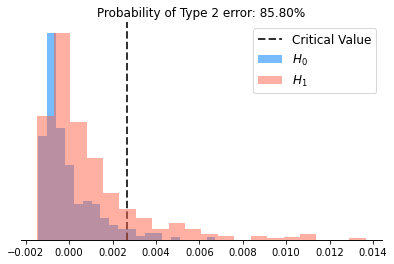

In [6]:
n_atoms   = 500
n_paths   = 128
alpha = 0.05

h0_dists, h1_dists = return_mmd_distributions(
    h0_paths, 
    h1_paths, 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub'
)

plot_dist(h0_dists, h1_dists, n_atoms, alpha, 'mmd_scaled_brownian.svg', svg=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [02:06<00:00, 16.20it/s]


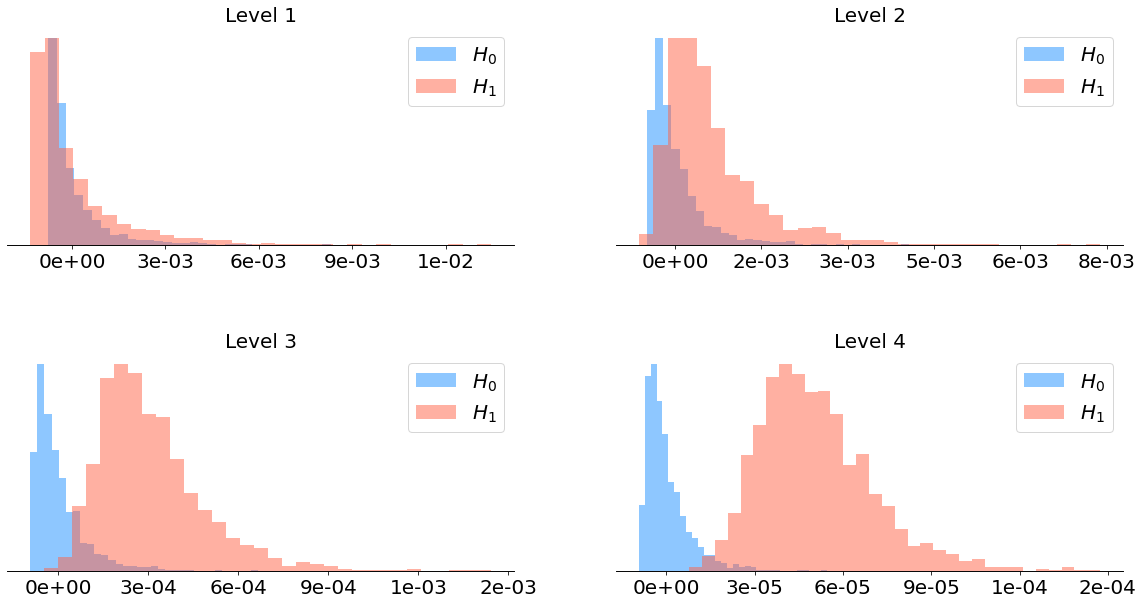

In [17]:
# Get the estimates from batches 
ks = [1, 2, 3, 4]

n_atoms = 2048
n_paths = 128


h0_Mk_vals, h1_Mk_vals = get_level_values(h0_paths, h1_paths, n_atoms, n_paths, ks, path_bank_size)
h0_Mk_vals = np.asarray(h0_Mk_vals)
h1_Mk_vals = np.asarray(h1_Mk_vals)

plot_level_contributions(h0_Mk_vals, h1_Mk_vals, n_atoms, ks, 'mmd_level_terms_scaled_brownian.svg', svg=True, scientific=True, filter=False)

#### Biased

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:53<00:00,  4.42it/s]


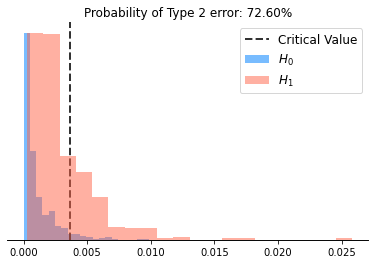

In [7]:
n_atoms   = 500
n_paths   = 128
alpha = 0.05

h0_dists, h1_dists = return_mmd_distributions(
    h0_paths, 
    h1_paths, 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='b'
)

plot_dist(h0_dists, h1_dists, n_atoms, alpha, 'mmd_scaled_brownian_biased.svg', svg=True)

### Apply Scaling <a class="anchor" id="scaling"></a>

In [7]:
scaling = 3

#### Unbiased

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:50<00:00,  4.52it/s]


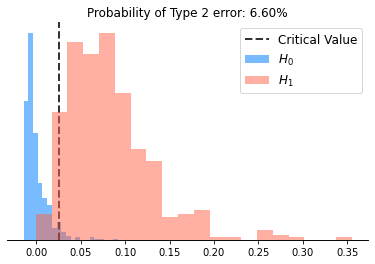

In [9]:
n_atoms   = 500
n_paths   = 128
alpha = 0.05

h0_dists, h1_dists = return_mmd_distributions(
    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h0_paths[:, :, :]), 
    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h1_paths[:, :, :]), 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub'
)

plot_dist(h0_dists, h1_dists, n_atoms, alpha, f'mmd_scaled_brownian_scaling_{scaling}.svg', svg=True)

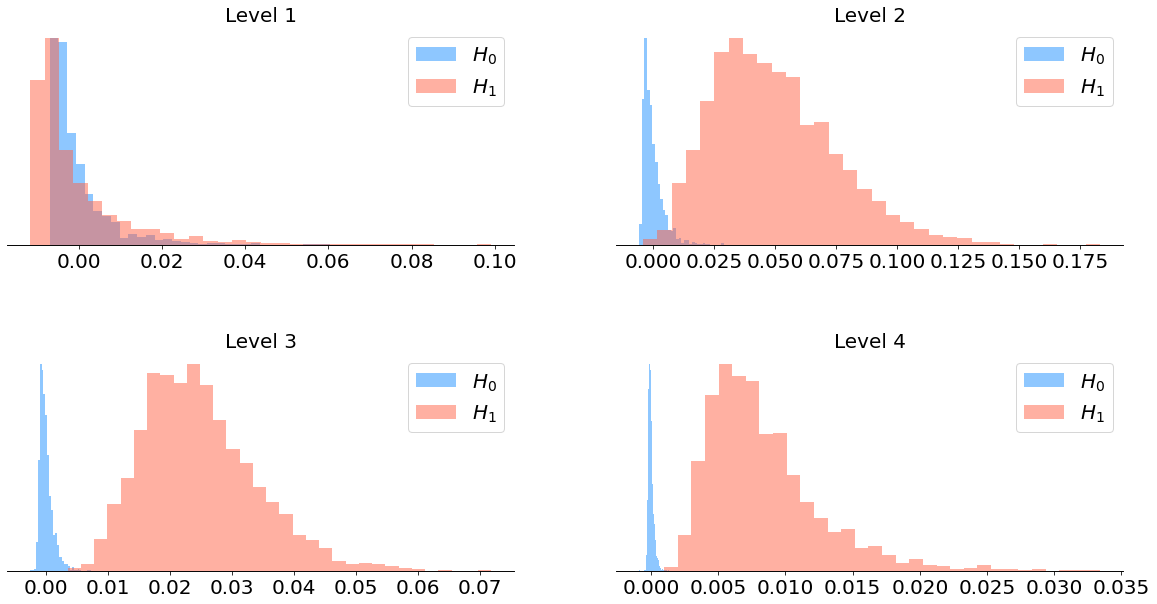

In [16]:
# Get the estimates from batches 
ks = [1, 2, 3, 4]

n_atoms = 2048
n_paths = 128


h0_Mk_vals, h1_Mk_vals = get_level_values(torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h0_paths[:, :, :]), 
                                          torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h1_paths[:, :, :]),
                                          n_atoms, n_paths, ks, path_bank_size)
h0_Mk_vals = np.asarray(h0_Mk_vals)
h1_Mk_vals = np.asarray(h1_Mk_vals)

plot_level_contributions(h0_Mk_vals, h1_Mk_vals, n_atoms, ks, f'mmd_level_terms_scaled_brownian_scaling_{scaling}.svg', filter=False, svg=True)

#### Biased

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:49<00:00,  4.55it/s]


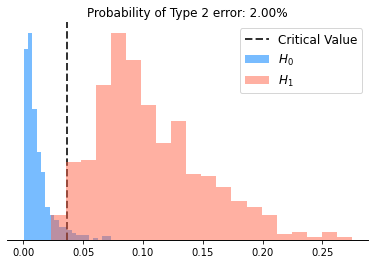

In [10]:
n_atoms   = 500
n_paths   = 128
alpha = 0.05

h0_dists, h1_dists = return_mmd_distributions(
    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h0_paths[:, :, :]), 
    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h1_paths[:, :, :]), 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='b'
)

plot_dist(h0_dists, h1_dists, n_atoms, alpha, f'mmd_scaled_brownian_scaling_{scaling}_biased.svg', svg=True)

### Relationship between Scaling, Batch Size, and Errors <a class="anchor" id="batchsize-scaling"></a>

In [3]:
scalings = np.linspace(0, 5, 20)
n_atoms   = 100
n_paths_list   = [20, 40, 60, 120]
alpha = 0.05

In [6]:
num_sim = 100
type1_list_unbiased, type2_list_unbiased = generate_error_probs_linear_kernel(signature_kernel,
                                                                              h0_paths,
                                                                              h1_paths,
                                                                              n_atoms,
                                                                              n_paths_list, 
                                                                              alpha, 
                                                                              scalings,
                                                                              'ub',
                                                                              num_sim,
                                                                              device, 
                                                                              filename='bm_unbiased',
                                                                              folder='ScaledBMData')

type1_list_biased, type2_list_biased = generate_error_probs_linear_kernel(signature_kernel,
                                                                          h0_paths, 
                                                                          h1_paths, 
                                                                          n_atoms, 
                                                                          n_paths_list,
                                                                          alpha, 
                                                                          scalings, 
                                                                          'b',
                                                                          num_sim, 
                                                                          device, 
                                                                          filename='bm_biased',
                                                                          folder='ScaledBMData')

In [4]:
with open("ScaledBMData/type1error_bm_unbiased", "rb") as fp: 
    type1_list_unbiased = pickle.load(fp)

with open("ScaledBMData/type2error_bm_unbiased", "rb") as fp: 
    type2_list_unbiased = pickle.load(fp)

with open("ScaledBMData/type1error_bm_biased", "rb") as fp: 
    type1_list_biased = pickle.load(fp)

with open("ScaledBMData/type2error_bm_biased", "rb") as fp: 
    type2_list_biased = pickle.load(fp)

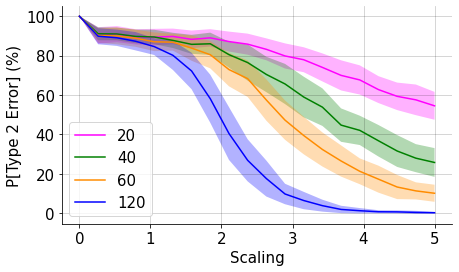

In [5]:
plot_type2_error(type2_list_unbiased, scalings, n_paths_list, title='Unbiased')

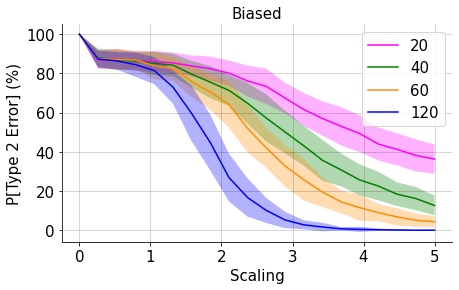

In [7]:
plot_type2_error(type2_list_biased, scalings, n_paths_list, title='Biased')

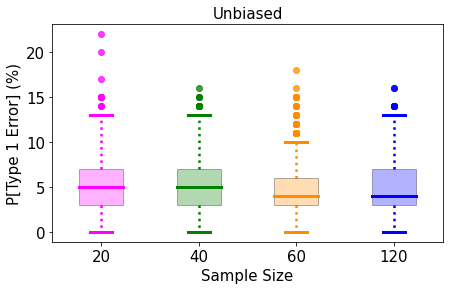

In [10]:
plot_aggregate_type1_error(type1_list_unbiased, n_paths_list, title='Unbiased')

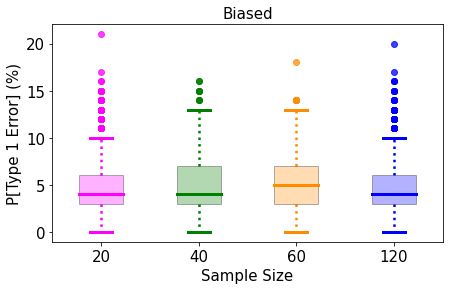

In [12]:
plot_aggregate_type1_error(type1_list_biased, n_paths_list, title='Biased')

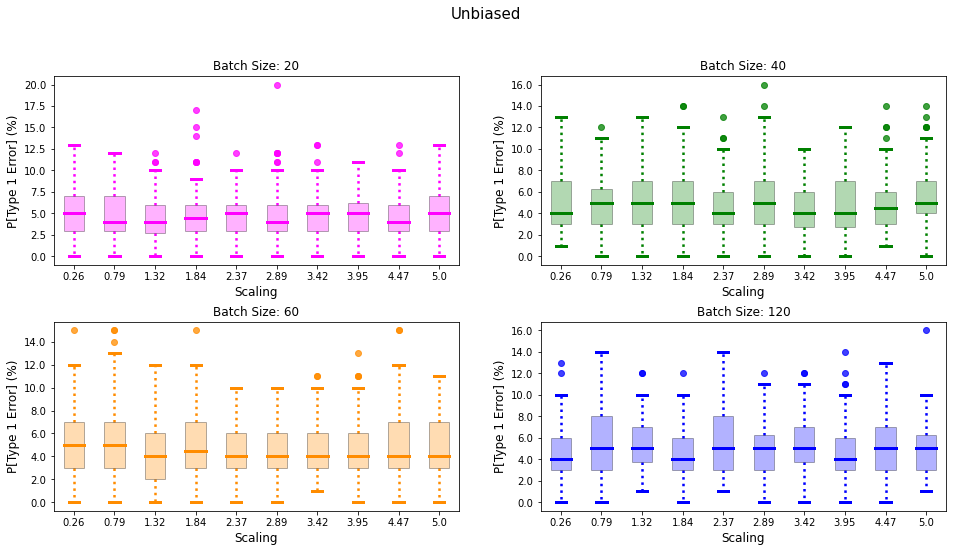

In [13]:
plot_type1_error(type1_list_unbiased, scalings, n_paths_list, title='Unbiased')

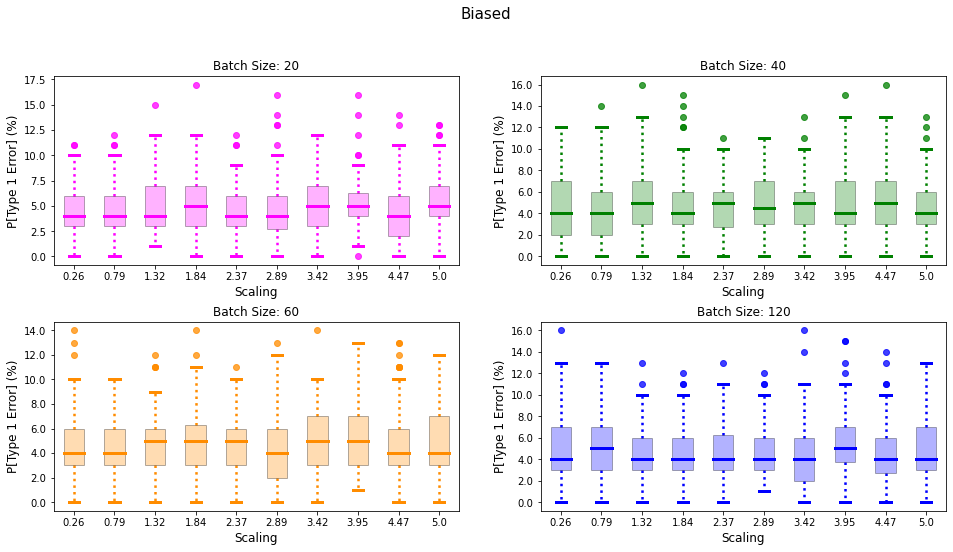

In [11]:
plot_type1_error(type1_list_biased, scalings, n_paths_list, title='Biased')

#### Extreme Scaling Values

In [6]:
scalings = np.linspace(1, 25, 30)
n_atoms   = 100
n_paths_list   = [20, 40]
alpha = 0.05

In [ ]:
num_sim = 100
type1_list_unbiased_extreme, type2_list_unbiased_extreme = generate_error_probs_linear_kernel(signature_kernel,
                                                                              h0_paths,
                                                                              h1_paths,
                                                                              n_atoms,
                                                                              n_paths_list, 
                                                                              alpha, 
                                                                              scalings,
                                                                              'ub',
                                                                              num_sim,
                                                                              device, 
                                                                              filename='bm_unbiased_extreme',
                                                                              folder='ScaledBMData')

type1_list_biased_extreme, type2_list_biased_extreme = generate_error_probs_linear_kernel(signature_kernel,
                                                                          h0_paths, 
                                                                          h1_paths, 
                                                                          n_atoms, 
                                                                          n_paths_list,
                                                                          alpha, 
                                                                          scalings, 
                                                                          'b',
                                                                          num_sim, 
                                                                          device, 
                                                                          filename='bm_biased_extreme',
                                                                          folder='ScaledBMData')

In [4]:
with open("ScaledBMData/type1error_bm_unbiased_extreme", "rb") as fp: 
    type1_list_unbiased_extreme = pickle.load(fp)

with open("ScaledBMData/type2error_bm_unbiased_extreme", "rb") as fp: 
    type2_list_unbiased_extreme = pickle.load(fp)

with open("ScaledBMData/type1error_bm_biased_extreme", "rb") as fp: 
    type1_list_biased_extreme = pickle.load(fp)

with open("ScaledBMData/type2error_bm_biased_extreme", "rb") as fp: 
    type2_list_biased_extreme = pickle.load(fp)

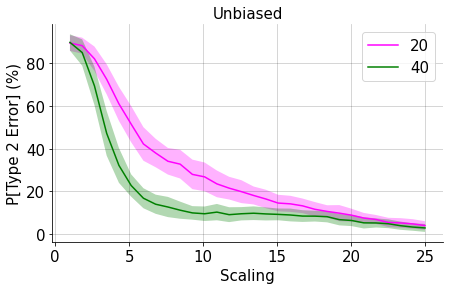

In [10]:
plot_type2_error(type2_list_unbiased_extreme, scalings, n_paths_list, title='Unbiased')

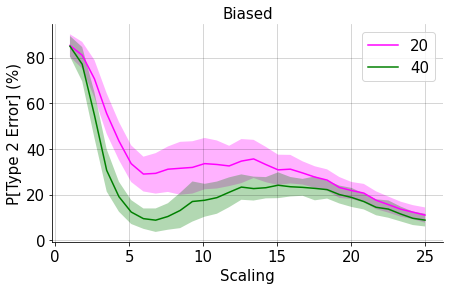

In [9]:
plot_type2_error(type2_list_biased_extreme, scalings, n_paths_list, title='Biased')

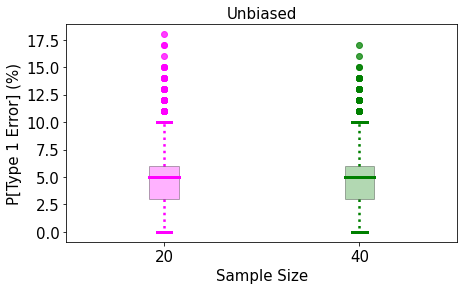

In [9]:
plot_aggregate_type1_error(type1_list_unbiased_extreme, n_paths_list, title='Unbiased')

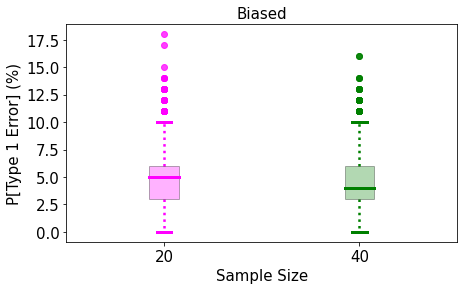

In [10]:
plot_aggregate_type1_error(type1_list_biased_extreme, n_paths_list, title='Biased')

### Probability of a Type 2 Error Occuring as a function of Batch Size and Dimension <a class="anchor" id="batchsize"></a>

In [ ]:
def compute_probability_errors(sig, beta, sigma_list, beta_list, n_atoms, alpha, scaling, n_paths_list, device, num_sim=20):
    
    prob_dict = defaultdict(list)
    
    h0_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, sig, path_bank_size, grid_points, T)), 0, 1).to(device=device)
    h1_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, beta, path_bank_size, grid_points, T)), 0, 1).to(device=device)
    d = 1
    for s, b in zip(sigma_list, beta_list):
        
        h0_paths = torch.cat((h0_paths, torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, s, path_bank_size, grid_points, T)), 0, 1).to(device=device)[:, :, :1]), axis=2)
        h1_paths = torch.cat((h1_paths, torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, b, path_bank_size, grid_points, T)), 0, 1).to(device=device)[:, :, :1]), axis=2)
    
        for n_paths in n_paths_list:
            
            prob_dict['Size'].append(n_paths)

            errors = []
            for _ in range(num_sim):
            
                h0_dists, h1_dists = return_mmd_distributions(
                    torch.multiply(torch.Tensor([scaling for _ in range(d)] + [2, 1]).to(device=device), h0_paths[:, :, :]), 
                    torch.multiply(torch.Tensor([scaling for _ in range(d)] + [2, 1]).to(device=device), h1_paths[:, :, :]), 
                    signature_kernel.compute_mmd, 
                    n_atoms=n_atoms, 
                    batch_size=n_paths,
                    estimator='b',
                    verbose=False
                )
                
                
                crit_val = np.sort(np.asarray(h0_dists))[int(n_atoms*(1-alpha))]
                errors.append(100*expected_type2_error(torch.tensor(h1_dists), crit_val).cpu().item())
            prob_dict['B S'].append(np.mean(errors))

            errors = []
            for _ in range(num_sim):
                h0_dists, h1_dists = return_mmd_distributions(
                    torch.multiply(torch.Tensor([1 for _ in range(d)] + [1, 1]).to(device=device), h0_paths[:, :, :]), 
                    torch.multiply(torch.Tensor([1 for _ in range(d)] + [1, 1]).to(device=device), h1_paths[:, :, :]), 
                    signature_kernel.compute_mmd, 
                    n_atoms=n_atoms, 
                    batch_size=n_paths,
                    estimator='b',
                    verbose=False
                )
                crit_val = np.sort(np.asarray(h0_dists))[int(n_atoms*(1-alpha))]
                errors.append(100*expected_type2_error(torch.tensor(h1_dists), crit_val).cpu().item())
            prob_dict['B NS'].append(np.mean(errors))

            errors = []
            for _ in range(num_sim):
                h0_dists, h1_dists = return_mmd_distributions(
                    torch.multiply(torch.Tensor([scaling for _ in range(d)] + [2, 1]).to(device=device), h0_paths[:, :, :]), 
                    torch.multiply(torch.Tensor([scaling for _ in range(d)] + [2, 1]).to(device=device), h1_paths[:, :, :]), 
                    signature_kernel.compute_mmd, 
                    n_atoms=n_atoms, 
                    batch_size=n_paths,
                    estimator='ub',
                    verbose=False
                )
                            
                crit_val = np.sort(np.asarray(h0_dists))[int(n_atoms*(1-alpha))]
                errors.append(100*expected_type2_error(torch.tensor(h1_dists), crit_val).cpu().item())
            prob_dict['Ub S'].append(np.mean(errors))

            errors = []
            for _ in range(num_sim):
                h0_dists, h1_dists = return_mmd_distributions(
                    torch.multiply(torch.Tensor([1 for _ in range(d)] + [1, 1]).to(device=device), h0_paths[:, :, :]), 
                    torch.multiply(torch.Tensor([1 for _ in range(d)] + [1, 1]).to(device=device), h1_paths[:, :, :]), 
                    signature_kernel.compute_mmd, 
                    n_atoms=n_atoms, 
                    batch_size=n_paths,
                    estimator='ub', 
                    verbose=False
                )
                crit_val = np.sort(np.asarray(h0_dists))[int(n_atoms*(1-alpha))]
                errors.append(100*expected_type2_error(torch.tensor(h1_dists), crit_val).cpu().item())
            prob_dict['Ub NS'].append(np.mean(errors))

            prob_dict['D'].append(d+2)
        
        d += 1
    
    return prob_dict

In [17]:
sigma_list = [0.5, 0.7, 0.1]
beta_list = [0.6, 0.8, 0.2]
n_atoms = 500
scaling = 2
n_paths_list = [16, 32, 64, 128, 256]
alpha = 0.05
prob_dict = compute_probability_errors(sig, beta, sigma_list, beta_list, n_atoms, alpha, scaling, n_paths_list, device)
df = pd.DataFrame(data=prob_dict)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
print(df)

    D  Size    B S  B NS  Ub S  Ub NS
0   3    16  77.80  90.5  87.8   92.2
1   3    32  72.10  89.9  84.6   92.6
2   3    64  58.20  87.4  75.3   90.5
3   3   128  33.16  84.0  50.3   88.1
4   3   256   6.80  70.2  15.2   76.1
5   4    16  77.40  86.8  88.2   92.3
6   4    32  68.40  85.4  83.9   91.3
7   4    64  53.60  83.4  75.6   89.3
8   4   128  31.00  73.8  57.2   83.5
9   4   256   8.13  52.4  24.5   68.8
10  5    16  61.40  86.6  88.3   92.4
11  5    32  49.40  85.3  83.2   91.3
12  5    64  28.90  82.0  72.8   89.1
13  5   128   6.90  73.5  42.6   84.5
14  5   256   0.10  49.3   4.4   67.1
